[I 2024-07-01 04:22:07,442] A new study created in memory with name: no-name-99c7b407-ab9a-46e8-8b2d-15336571e1b3
train loss: 1.63e-04 | test loss: 1.63e-04 | reg: 4.59e+01 : 100%|█| 141/141 [22:27<00:00,  9.55s/it
[I 2024-07-01 04:44:34,946] Trial 0 finished with value: 2.7111466849305543e-08 and parameters: {'width_1': 30, 'width_2': 10, 'grid': 13, 'k': 4, 'steps': 141}. Best is trial 0 with value: 2.7111466849305543e-08.


Best hyperparameters:  {'width_1': 30, 'width_2': 10, 'grid': 13, 'k': 4, 'steps': 141}


train loss: 1.11e-04 | test loss: 1.11e-04 | reg: 4.63e+01 : 100%|█| 141/141 [18:52<00:00,  8.03s/it


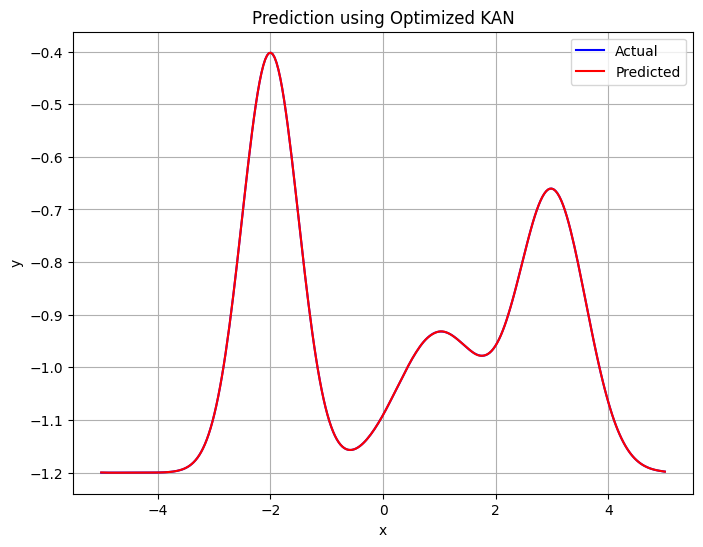

In [ ]:
from kan import KAN, create_dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import optuna

def gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def actual_func(x):
    return gaussian(x, -2, 0.5) + 0.5 * gaussian(x, 1, 0.75) + 0.8 * gaussian(x, 3, 0.6) - 1.2

def objective(trial):
    width_1 = trial.suggest_int('width_1', 8, 32)
    width_2 = trial.suggest_int('width_2', 8, 32)
    grid = trial.suggest_int('grid', 5, 15)
    k = trial.suggest_int('k', 1, 5)
    steps = trial.suggest_int('steps', 100, 200)

    kan_model = KAN(width=[1, width_1, width_2, 1], grid=grid, k=k)

    f = lambda x: torch.tensor(gaussian(x, -2, 0.5) + 0.5 * gaussian(x, 1, 0.75) + 0.8 * gaussian(x, 3, 0.6) - 1.2, dtype=torch.float32)

    train_x = torch.tensor([[x] for x in np.linspace(-5, 5, 500)], dtype=torch.float32)
    train_y = f(train_x.numpy())
    dataset = {'train_input': train_x, 'train_label': train_y,
               'test_input': train_x, 'test_label': train_y}

    kan_model.train(dataset, opt='LBFGS', steps=steps)

    x_values = torch.tensor([[x] for x in np.linspace(-5, 5, 300)], dtype=torch.float32)

    with torch.no_grad():
        y_predicted = kan_model.forward(x_values).squeeze().numpy()

    y_actual = actual_func(x_values.squeeze().numpy())

    mse = np.mean((y_actual - y_predicted) ** 2)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

best_params = study.best_params
print("Best hyperparameters: ", best_params)

kan_model = KAN(width=[1, best_params['width_1'], best_params['width_2'], 1], grid=best_params['grid'], k=best_params['k'])

train_x = torch.tensor([[x] for x in np.linspace(-5, 5, 500)], dtype=torch.float32)
train_y = torch.tensor(actual_func(train_x.numpy()), dtype=torch.float32)
dataset = {'train_input': train_x, 'train_label': train_y,
           'test_input': train_x, 'test_label': train_y}

kan_model.train(dataset, opt='LBFGS', steps=best_params['steps'])

x_values = torch.tensor([[x] for x in np.linspace(-5, 5, 300)], dtype=torch.float32)

with torch.no_grad():
    y_predicted = kan_model.forward(x_values).squeeze().numpy()

y_actual = actual_func(x_values.squeeze().numpy())

plt.figure(figsize=(8, 6))
plt.plot(x_values.numpy(), y_actual, label='Actual', color='blue')
plt.plot(x_values.numpy(), y_predicted, label='Predicted', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction using Optimized KAN')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
pip install pykan


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00
